# Test on the Harvard Covid dataset
**This notebook goal is to use the PCA circle correlation method on the Harvard covid dataset found here:**  
https://github.com/wxwx1993/PM_COVID/

##### Usual imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn import decomposition
from sklearn import datasets
from scipy.spatial import distance
from geopy.distance import geodesic
from geopy.geocoders import Nominatim

##### Loading the pm2.5 particle dataset and the death ratio by country in USA

In [2]:
pm25_df = pd.read_csv("./Data/county_pm25.csv")
pm25_df = pm25_df.dropna()
pm25_df = pm25_df.groupby('fips', as_index=False).agg({'pm25' : 'mean'})
pm25_df

,fips,pm25
0,1001.0,11.712587
1,1003.0,10.077723
2,1005.0,10.981967
3,1007.0,11.998715
4,1009.0,11.793023
...,...,...
3092,56037.0,4.896375
3093,56039.0,3.867683
3094,56041.0,5.088060
3095,56043.0,5.025529


In [3]:
mortality_df = pd.read_csv("./Data/county_old_mortality.txt", sep='\t')
mortality_df['County'] = mortality_df['County'].apply(lambda x: x[-2:])
mortality_df

,County,County Code,Deaths,Population,Crude Rate
NaN,AL,1001,5338,109652,4868.1
NaN,AL,1003,22452,526184,4266.9
NaN,AL,1005,3675,71542,5136.8
NaN,AL,1007,2685,51438,5219.9
NaN,AL,1009,7076,146136,4842.1
...,...,...,...,...,...
NaN,WY,56037,2991,64222,4657.3
NaN,WY,56039,946,35161,2690.5
NaN,WY,56041,1408,32316,4357.0
NaN,WY,56043,1228,26285,4671.9


##### Merge both dataset using the FIPS (county code)

In [4]:
merged_df = mortality_df.merge(pm25_df, left_on='County Code', right_on='fips')

main_df = merged_df[['County', 'Crude Rate', 'pm25']]
main_df = main_df.set_index('County')
main_df

,Crude Rate,pm25
County,,
AL,4868.1,11.712587
AL,4266.9,10.077723
AL,5136.8,10.981967
AL,5219.9,11.998715
AL,4842.1,11.793023
...,...,...
WY,4657.3,4.896375
WY,2690.5,3.867683
WY,4357.0,5.088060


##### Apply PCA after normalization

In [5]:
df = main_df
df_norm = (df-df.mean())/df.std()
pca = decomposition.PCA(n_components=2)
PCA_df = pd.DataFrame(data = pca.fit_transform(df_norm), columns=['Component #1', 'Component #2'])
print("Singular values:", pca.singular_values_)

Singular values: [63.23665332 46.8094614 ]


##### Correlation circle

,Crude Rate,pm25
0,-0.707107,-0.707107
1,-0.707107,0.707107


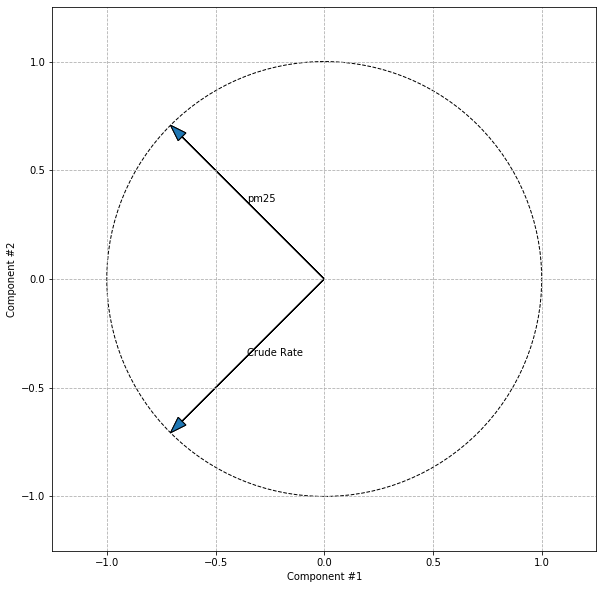

In [6]:
circle_df = pd.DataFrame(data=[[pca.components_[c,n] for n in range(pca.n_components_)] for c in range(pca.n_components_)],
             index=[0,1],
             columns = df_norm.columns)
display(circle_df)


# Plot 0 vs 1
fig, ax = plt.subplots(figsize=(10,10))
plt.xlim(-1.25,1.25)
plt.ylim(-1.25,1.25)

circle1 = plt.Circle((0, 0), 1, color='k', linestyle='--', fill=False)
ax.add_artist(circle1)

for c in df_norm:
    ax.annotate(c, xy=(circle_df[c][0]/2, circle_df[c][1]/2))
    ax.add_artist(plt.arrow(0, 0, circle_df[c][0], circle_df[c][1], head_width=0.05,length_includes_head=True))
    
ax.set_aspect(1)
plt.grid(linestyle='--')
plt.xlabel('Component #1')
plt.ylabel('Component #2')
plt.savefig('../figures/harvard_data_corr_circle.png')
plt.show()

We can see with the correlation circle that both features are not correlated!

This can also be observed by looking at the "raw" data, there are no clear relation between the *Crude rate* and the concentration of *PM2.5*

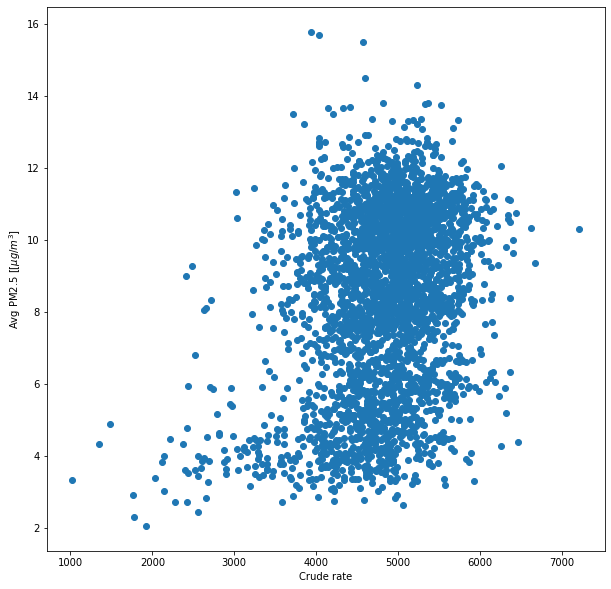

In [7]:
plt.figure(figsize=(10,10))
plt.scatter(main_df.iloc[:,0],main_df.iloc[:,1])
plt.xlabel('Crude rate')
plt.ylabel('Avg PM2.5 [$[\mu g/m^3$]')
plt.show()